# Behavior Cloningを使用して実機の自動運転の学習をしたい。
学習データは、自分が運転したデータを使用する。
データの形式は、画像とその時の操作であるsteeringとthrottleの値が保存されている。


In [1]:
import numpy as np
import gymnasium
from gymnasium.wrappers import TimeLimit
from imitation.data import rollout
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.policies import ActorCriticCnnPolicy

from gymnasium.spaces import Box
from gymnasium.envs.registration import register
import racing_gym
import os
import json
from PIL import Image
import torch
import time


/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 環境を事務のレジストリに追加する

In [2]:
gymnasium.register(
    id = 'RacingEnv-v0',
    entry_point = 'racing_gym.envs.racing_env:RacingEnv',
    max_episode_steps = 1000,
)
gymnasium.register(
    id = 'RacingEnv-v1',
    entry_point = 'racing_gym.envs.racing_env1:RacingEnv1',
    max_episode_steps = 1000,
)
gymnasium.register(
    id = 'RacingEnv-v2',
    entry_point = 'racing_gym.envs.racing_env2:RacingEnv2',
    max_episode_steps = 1000,
)

/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment RacingEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment RacingEnv-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment RacingEnv-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


ベクトル化された環境を作成する

In [2]:
import os
import json
import numpy as np
from PIL import Image

def load_expert_data(data_path):
    # expert_dataの初期化
    expert_data = {'images': [], 'actions': []}
    # print(expert_data)
    # count = 0

    # 画像ファイルに対応するJSONファイルを取得
    json_file_list = [json_file for json_file in os.listdir(data_path) if json_file.startswith('record_') and json_file.endswith('.json')]
    # print(len(json_file_list))

    for json_file in json_file_list:
        # count += 1
        # print(count)
        # print(json_file)

        # レコードのファイルパスを構築
        json_path = os.path.join(data_path, json_file)
        # print(json_path)

        # レコードの読み込み
        try:
            with open(json_path, 'r') as json_file:
                record_data = json.load(json_file)
        except FileNotFoundError:
            print(f"エラー：{json_path} でJSONファイルが見つかりませんでした。")
            continue
        except json.JSONDecodeError:
            print(f"エラー：{json_path} のJSONファイルのデコードに失敗しました。")
            continue

        # 画像データの読み込み
        image_file = record_data.get('cam/image_array', '')  # 画像ファイル名をJSONから取得
        # print(image_file)
        image_path = os.path.join(data_path, image_file)
        # print(image_path)
        try:
            image_data = np.array(Image.open(image_path))
        except FileNotFoundError:
            print(f"エラー：{image_path} で画像ファイルが見つかりませんでした。")
            continue

        # expert_dataに追加
        expert_data['images'].append(image_data)
        expert_data['actions'].append([record_data.get('user/angle', 0), record_data.get('user/throttle', 0)])

    return expert_data


In [3]:
import os
import json
import numpy as np
from PIL import Image

def load_expert_data_directory(parent_directory):
    # parent_directory内のすべてのディレクトリを取得
    subdirectories = [os.path.join(parent_directory, d) for d in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, d))]
    
    all_expert_data = []  # すべてのディレクトリのexpert_dataを格納するリスト

    for data_path in subdirectories:
        # ディレクトリごとにexpert_dataの初期化
        expert_data = {'images': [], 'actions': []}

        # 画像ファイルに対応するJSONファイルを取得
        json_file_list = [json_file for json_file in os.listdir(data_path) if json_file.startswith('record_') and json_file.endswith('.json')]

        for json_file in json_file_list:
            # レコードのファイルパスを構築
            json_path = os.path.join(data_path, json_file)

            # レコードの読み込み
            try:
                with open(json_path, 'r') as json_file:
                    record_data = json.load(json_file)
            except FileNotFoundError:
                print(f"エラー：{json_path} でJSONファイルが見つかりませんでした。")
                continue
            except json.JSONDecodeError:
                print(f"エラー：{json_path} のJSONファイルのデコードに失敗しました。")
                continue

            # 画像データの読み込み
            image_file = record_data.get('cam/image_array', '')  # 画像ファイル名をJSONから取得
            image_path = os.path.join(data_path, image_file)
            try:
                image_data = np.array(Image.open(image_path))
            except FileNotFoundError:
                print(f"エラー：{image_path} で画像ファイルが見つかりませんでした。")
                continue

            # expert_dataに追加
            expert_data['images'].append(image_data)
            expert_data['actions'].append([record_data.get('user/angle', 0), record_data.get('user/throttle', 0)])
        
        # すべてのディレクトリのexpert_dataをリストに追加
        all_expert_data.append(expert_data)


    return all_expert_data


In [4]:
expert_data2 = load_expert_data_directory('../../autorace/data/L/')



In [15]:
for i in range(len(expert_data2)):
    print(i+1, ":", len(expert_data2[i]['images']))

print(expert_data2[0]['images'][0].shape)

1 : 2271
2 : 1852
3 : 1321
4 : 1400
5 : 2704
6 : 3493
7 : 1491
8 : 1215
9 : 1988
10 : 813
11 : 911
12 : 1309
(224, 224, 3)


In [ ]:

print(expert_data2[0]['images'][0])

In [6]:
# expert_data_path = '../../Data/autorace/O/tub_9_24-01-09'
# expert_data_path = '../../autorace/data/tub_9_24-01-09'
# expert_data = load_expert_data(expert_data_path)
# print(expert_data['images'][0].shape)
# reshaped_expert_data = expert_data

reshaped_all_expert_data = expert_data2.copy()
# すべてのディレクトリに対して
for i in range(len(reshaped_all_expert_data)):
    # すべての画像を変換
    for j in range(len(reshaped_all_expert_data[i]['images'])):
        # 画像の軸の順序を変更
        reshaped_image = np.transpose(reshaped_all_expert_data[i]['images'][j], (2, 0, 1))
        
        # expert_dataに変更を反映
        reshaped_all_expert_data[i]['images'][j] = reshaped_image.copy()

# 形状を確認
print(reshaped_all_expert_data[0]['images'][0].shape)

for i in range(len(reshaped_all_expert_data)):
    for j in range(len(reshaped_all_expert_data[i]['images'])):
        if reshaped_all_expert_data[i]['images'][j].shape != (3, 224, 224):
            print(i, j)

expert_data2 = load_expert_data_directory('../../autorace/data/L/')

(3, 224, 224)


In [7]:
print(reshaped_all_expert_data[0]['images'][0].shape)
print(expert_data2[0]['images'][0].shape)

(3, 224, 224)
(224, 224, 3)


In [5]:
# expert_data_path = '../../Data/autorace/O/tub_9_24-01-09'
# expert_data_path = '../../autorace/data/tub_9_24-01-09'
# expert_data = load_expert_data(expert_data_path)
# reshaped_expert_data = 
print(expert_data['actions'])
env = gymnasium.make('RacingEnv-v0', expert_data=expert_data)
env1 = gymnasium.make('RacingEnv-v1', expert_data=reshaped_expert_data)

[[1.0, 0.7], [1.0, 0.8], [1.0, 0.8], [1.0, 0.7], [0.0, 0.8], [0.5360881374553667, 0.8], [1.0, 0.7], [1.0, 0.8], [1.0, 0.7], [1.0, 0.8], [1.0, 0.65], [1.0, 0.7], [0.0, 0.8], [0.0, 0.8], [0.0, 0.8], [1.0, 0.65], [1.0, 0.8], [1.0, 0.65], [0.0, 0.65], [0.0, 0.7], [0.0, 0.65], [1.0, 0.8], [0.0, -0.0], [0.0, 0.7], [1.0, 0.65], [1.0, 0.8], [1.0, 0.65], [0.0, 0.7], [1.0, 0.65], [1.0, 0.8], [1.0, 0.8], [1.0, 0.7], [0.0, 0.7], [1.0, 0.8], [0.0, 0.65], [0.0, 0.8], [0.0, 0.8], [1.0, 0.8], [1.0, 0.7], [1.0, 0.8], [1.0, 0.8], [1.0, 0.8], [0.0, 0.7], [1.0, 0.8], [0.0, 0.65], [1.0, 0.65], [1.0, 0.65], [0.0, 0.8], [0.0, 0.8], [0.0, 0.8], [0.0, 0.7], [1.0, 0.65], [0.0, 0.8], [0.0, 0.65], [0.0, 0.8], [0.0, 0.8], [1.0, 0.65], [1.0, 0.8], [0.0, 0.65], [0.0, 0.8], [0.0, 0.65], [1.0, 0.8], [1.0, 0.8], [1.0, 0.8], [1.0, 0.65], [1.0, 0.65], [1.0, 0.65], [1.0, 0.8], [0.0, 0.65], [1.0, 0.65], [0.0, 0.65], [1.0, 0.7], [1.0, 0.7], [1.0, 0.8], [0.0, 0.8], [1.0, 0.65], [1.0, 0.65], [0.0, 0.8], [1.0, 0.8], [1.0, 0.8]

/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment RacingEnv-v0 is out of date. You should consider upgrading to version `v2`.
  logger.deprecation(
/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment RacingEnv-v1 is out of date. You should consider upgrading to version `v2`.
  logger.deprecation(


In [6]:
env_id2 = 'RacingEnv-v2'
try:
    env2 = gymnasium.make(env_id2)
    print(f"Environment '{env_id2}' is successfully registered.")
except gymnasium.error.Error as e:
    print(f"Error: {e}")

Environment 'RacingEnv-v2' is successfully registered.


In [170]:
# env = gym.make('RacingEnv-v0')

# print(list(gym.envs.registry.keys()))
# print(env.expert_data)

In [8]:
import gymnasium
env_id = 'RacingEnv-v0'  # あなたの環境の名前に変更してください
try:
    env = gymnasium.make(env_id, expert_data=expert_data2)
    print(f"Environment '{env_id}' is successfully registered.")
except gymnasium.error.Error as e:
    print(f"Error: {e}")
env_id1 = 'RacingEnv-v1'  # あなたの環境の名前に変更してください
try:
    env1 = gymnasium.make(env_id1, expert_data=reshaped_all_expert_data)
    print(f"Environment '{env_id1}' is successfully registered.")
except gymnasium.error.Error as e:
    print(f"Error: {e}")

4
Environment 'RacingEnv-v0' is successfully registered.
10
Environment 'RacingEnv-v1' is successfully registered.


/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment RacingEnv-v0 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment RacingEnv-v1 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(


In [7]:
venv2 = make_vec_env(
    "RacingEnv-v2",
    rng = np.random.default_rng(),
    n_envs = 4,
    post_wrappers = [lambda env2, _: RolloutInfoWrapper(env2)],
)

In [9]:
def _make_env():
    """Helper function to create a single environment. Put any logic here, but make sure to return a RolloutInfoWrapper."""
    _env = gymnasium.make("RacingEnv-v0", expert_data=expert_data2)
    _env = RolloutInfoWrapper(_env)
    return _env

venv = DummyVecEnv([_make_env for _ in range(4)])

def _make_env():
    """Helper function to create a single environment. Put any logic here, but make sure to return a RolloutInfoWrapper."""
    _env1 = gymnasium.make("RacingEnv-v1", expert_data=reshaped_all_expert_data)
    _env1 = RolloutInfoWrapper(_env1)
    return _env1

venv1 = DummyVecEnv([_make_env for _ in range(4)])

11
11
0
6
4
10
1
10


In [10]:

# # 環境の初期化
# env = gymnasium.make("RacingEnv-v0", expert_data=expert_data)

# num_episodes = 1000

# # 学習ループなどで利用
# # for _ in range(num_episodes):
# #     action = policy.predict(observation)  # ポリシーによるアクション予測
# #     observation, reward, done, info = env.step(action)
# #     if done:
# #         observation = env.reset()

# env.reset()
# next_state, reward, done, trunc, info = env.step(action=[0, 0])
# print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

In [11]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy

model = PPO(MlpPolicy, venv, verbose=1)


# 観測空間の形状を確認
obs_shape = model.observation_space.shape
print(f"Observation space shape: {obs_shape}")

Using cuda device
Wrapping the env in a VecTransposeImage.
Observation space shape: (3, 224, 224)


In [10]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.ppo import CnnPolicy
from stable_baselines3.common.evaluation import evaluate_policy


expert = PPO(
    policy=CnnPolicy,
    env=env1,
    seed=0,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    n_steps=64,
)
reward, _ = evaluate_policy(expert, env1, 10)
print(f"Reward before training: {reward}")


# Note: if you followed step 2a, i.e. registered the environment, you can use the environment name directly

# expert = PPO(
#     policy=MlpPolicy,
#     env="custom/ObservationMatching-v0",
#     seed=0,
#     batch_size=64,
#     ent_coef=0.0,
#     learning_rate=0.0003,
#     n_epochs=10,
#     n_steps=64,
# )
expert.learn(100000)  # Note: set to 100000 to train a proficient expert
reward, _ = evaluate_policy(expert, expert.get_env(), 10)
print(f"Expert reward: {reward}")

/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


5
0
3
11
3
7
9
3
5
2
4
Reward before training: 895.3097885519267
7
9
1
1
3
6
6
8
2
1
3
8
4
2
5
6
9
2
6
4
9
0
3
2
8
11
5
11
8
3
10
5
3
5
5
11
7
2
9
7
6
2
8
5
1
2
2
4
9
0
11
4
10
2
7
6
3
6
1
3
4
3
3
6
11
5
8
10
11
Expert reward: 1255.4572827


In [142]:
from typing import List
ACTION_NAME: List[str] = ['steer', 'throttle']
weight = {
    'steer': 1.0,
    'throttle': 1.0
}
def calculate_reward(action, current_expert_data):
    # MSEを使用する
    reward = 0
    count = 0 
    for i, action_name in enumerate(ACTION_NAME):
        count += 1
        reward += weight[action_name] * (action[i] - current_expert_data[i]) ** 2
    print(count)
    return 1/(reward+1)

action = transitions[1232]['acts']
current_expert_data = expert_data['actions'][12]
calculate_reward(action, current_expert_data)

2


0.5367880615422704

In [11]:
rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    venv1,
    rollout.make_sample_until(min_timesteps=None, min_episodes=50),
    rng=rng,
)
transitions = rollout.flatten_trajectories(rollouts)

9
5
11
6
10
3
1
4
10
3
10
9
4
11
9
10
4
1
5
9
10
4
9
0
6
1
2
9
5
11
0
5
5
3
6
9
9
6
5
8
10
3
3
2
0
9
8
8
8
0
1
4
5
3
2
0
6
0
8


In [29]:
# def policy_demo(policy):
#     # 環境の初期化
#     env = gymnasium.make("RacingEnv-v0", expert_data=expert_data)

#     # 環境のリセット
#     observation = env.reset()

#     # エピソードのループ
#     for i in range(1000):
#         # アクションの予測
#         action, _ = policy.predict(observation, deterministic=True)

#         # 環境のステップを実行
#         observation, reward, done, info = env.step(action)

#         # 終了判定
#         if done:
#             print("Episode finished after {} timesteps".format(i + 1))
#             break

your_observation = transitions[0]['obs']
# モデルの出力を計算
with torch.no_grad():
    observation_tensor = torch.tensor(your_observation, dtype=torch.float32).unsqueeze(0).to("cuda")
    
    # 計測開始
    start = time.time()

    predicted_action1 = expert.policy(observation_tensor)
    predicted_action2 = expert.predict(your_observation)
    
    # 計測終了
    end = time.time()

print("Predicted Action:", predicted_action1)
print("Predicted Action:", predicted_action2)

predicted_action1 = predicted_action1[0].cpu().numpy()
predicted_action2 = predicted_action2[0]

print("Predicted Action:", predicted_action1)
print("Predicted Action:", predicted_action2)

# 計測時間を表示 (hz: 1秒間に何回処理が実行されたか)
print(f"Time: {end - start}")
print(f"Hz: {1 / (end - start)}")

Predicted Action: (tensor([[ 1.4942, -1.7506]], device='cuda:0'), tensor([[22.0067]], device='cuda:0'), tensor([-5.0540], device='cuda:0'))
Predicted Action: (array([-0.73350257,  0.        ], dtype=float32), None)
Predicted Action: [[ 1.4942307 -1.7505597]]
Predicted Action: [-0.73350257  0.        ]
Time: 0.0015642642974853516
Hz: 639.2781588172535


In [53]:
print(len(transitions))
count = 0
my_list = []
# for i in range(len(transitions)-2):
#     if np.all(transitions[999]['next_obs'] == transitions[i+1]['next_obs']):
#         count += 1
#         my_list.append(i)
# print(len(my_list))
# for i in range(len(transitions)):
#     actions = transitions[i]['acts']
for i in range(len(expert_data2)):
    for j in range(len(expert_data2[i])):
        actions = expert_data2[i]['actions'][j]


    steer = [action[0] for action in expert_data2[i]['actions']]
    throttel = [action[1] for action in expert_data2[i]['actions']]
    print("Min steer:", np.min(steer))
    print("Max steer:", np.max(steer))
    # print(steer)
    print("Min throttel:", np.min(throttel))
    print("Max throttel:", np.max(throttel))
    # print(throttel)

57316
Min steer: -1.0
Max steer: 1.0
Min throttel: 0.041261024811548204
Max throttel: 1.0
Min steer: -1.0
Max steer: 1.0
Min throttel: 0.010315256202887051
Max throttel: 1.0
Min steer: -1.0
Max steer: 1.0
Min throttel: 0.020630512405774102
Max throttel: 1.0
Min steer: -1.0
Max steer: 1.0
Min throttel: 0.020630512405774102
Max throttel: 1.0
Min steer: -1.0
Max steer: 1.0
Min throttel: 0.020630512405774102
Max throttel: 1.0
Min steer: -1.0
Max steer: 1.0
Min throttel: 0.010315256202887051
Max throttel: 1.0
Min steer: -1.0
Max steer: 1.0
Min throttel: 0.010315256202887051
Max throttel: 1.0
Min steer: -1.0
Max steer: 1.0
Min throttel: 0.041261024811548204
Max throttel: 1.0
Min steer: -1.0
Max steer: 1.0
Min throttel: 0.08249153111362041
Max throttel: 1.0
Min steer: -1.0
Max steer: 1.0
Min throttel: 0.05876796777245399
Max throttel: 0.95
Min steer: -1.0
Max steer: 1.0
Min throttel: 0.041261024811548204
Max throttel: 1.0
Min steer: -1.0
Max steer: 1.0
Min throttel: 0.020630512405774102
Max t

In [1]:
print(transitions[0]['acts'])

NameError: name 'transitions' is not defined

In [12]:
from imitation.algorithms import bc
from imitation.util import logger

bc_logger = logger.configure('./log/')
bc_trainer = bc.BC(
    observation_space=env1.observation_space,
    action_space=env1.action_space,
    demonstrations=transitions,
    rng=rng,
    policy=ActorCriticCnnPolicy(
        observation_space=env1.observation_space,
        action_space=env1.action_space,
        features_extractor_kwargs=dict(features_dim=256),
        lr_schedule=lambda _: 0.0003,
        ),
    batch_size=2048,
    device="cuda:0",
    custom_logger=bc_logger
)


In [ ]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, venv1, 10)
print(f"Reward before training: {reward_before_training}")

In [46]:
bc_trainer.train(n_epochs=150, log_interval=1)
reward_after_training, _ = evaluate_policy(bc_trainer.policy, venv1, 10)
print(f"Reward after training: {reward_after_training}")

28batch [00:09,  2.87batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 27       |
|    ent_loss       | -0.00278 |
|    entropy        | 2.78     |
|    epoch          | 1        |
|    l2_loss        | 0        |
|    l2_norm        | 468      |
|    loss           | 2.01     |
|    neglogp        | 2.01     |
|    prob_true_act  | 0.139    |
|    samples_so_far | 57344    |
--------------------------------


56batch [00:19,  2.87batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 55       |
|    ent_loss       | -0.00272 |
|    entropy        | 2.72     |
|    epoch          | 2        |
|    l2_loss        | 0        |
|    l2_norm        | 499      |
|    loss           | 1.88     |
|    neglogp        | 1.88     |
|    prob_true_act  | 0.156    |
|    samples_so_far | 114688   |
--------------------------------


84batch [00:30,  2.59batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 83       |
|    ent_loss       | -0.00266 |
|    entropy        | 2.66     |
|    epoch          | 3        |
|    l2_loss        | 0        |
|    l2_norm        | 521      |
|    loss           | 1.83     |
|    neglogp        | 1.83     |
|    prob_true_act  | 0.164    |
|    samples_so_far | 172032   |
--------------------------------


112batch [00:40,  2.83batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 111      |
|    ent_loss       | -0.0026  |
|    entropy        | 2.6      |
|    epoch          | 4        |
|    l2_loss        | 0        |
|    l2_norm        | 545      |
|    loss           | 1.76     |
|    neglogp        | 1.77     |
|    prob_true_act  | 0.176    |
|    samples_so_far | 229376   |
--------------------------------


140batch [00:51,  2.71batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 139      |
|    ent_loss       | -0.00254 |
|    entropy        | 2.54     |
|    epoch          | 5        |
|    l2_loss        | 0        |
|    l2_norm        | 569      |
|    loss           | 1.72     |
|    neglogp        | 1.72     |
|    prob_true_act  | 0.184    |
|    samples_so_far | 286720   |
--------------------------------


168batch [01:01,  2.65batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 167      |
|    ent_loss       | -0.00249 |
|    entropy        | 2.49     |
|    epoch          | 6        |
|    l2_loss        | 0        |
|    l2_norm        | 591      |
|    loss           | 1.67     |
|    neglogp        | 1.68     |
|    prob_true_act  | 0.194    |
|    samples_so_far | 344064   |
--------------------------------


196batch [01:11,  2.77batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 195      |
|    ent_loss       | -0.00243 |
|    entropy        | 2.43     |
|    epoch          | 7        |
|    l2_loss        | 0        |
|    l2_norm        | 612      |
|    loss           | 1.63     |
|    neglogp        | 1.64     |
|    prob_true_act  | 0.203    |
|    samples_so_far | 401408   |
--------------------------------


224batch [01:22,  2.79batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 223      |
|    ent_loss       | -0.00237 |
|    entropy        | 2.37     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 633      |
|    loss           | 1.57     |
|    neglogp        | 1.58     |
|    prob_true_act  | 0.215    |
|    samples_so_far | 458752   |
--------------------------------


252batch [01:32,  2.66batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 251      |
|    ent_loss       | -0.00232 |
|    entropy        | 2.32     |
|    epoch          | 9        |
|    l2_loss        | 0        |
|    l2_norm        | 655      |
|    loss           | 1.52     |
|    neglogp        | 1.52     |
|    prob_true_act  | 0.227    |
|    samples_so_far | 516096   |
--------------------------------


280batch [01:43,  2.80batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 279      |
|    ent_loss       | -0.00226 |
|    entropy        | 2.26     |
|    epoch          | 10       |
|    l2_loss        | 0        |
|    l2_norm        | 675      |
|    loss           | 1.48     |
|    neglogp        | 1.48     |
|    prob_true_act  | 0.236    |
|    samples_so_far | 573440   |
--------------------------------


308batch [01:53,  2.76batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 307      |
|    ent_loss       | -0.00221 |
|    entropy        | 2.21     |
|    epoch          | 11       |
|    l2_loss        | 0        |
|    l2_norm        | 695      |
|    loss           | 1.43     |
|    neglogp        | 1.44     |
|    prob_true_act  | 0.249    |
|    samples_so_far | 630784   |
--------------------------------


336batch [02:04,  2.76batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 335      |
|    ent_loss       | -0.00215 |
|    entropy        | 2.15     |
|    epoch          | 12       |
|    l2_loss        | 0        |
|    l2_norm        | 715      |
|    loss           | 1.4      |
|    neglogp        | 1.4      |
|    prob_true_act  | 0.259    |
|    samples_so_far | 688128   |
--------------------------------


364batch [02:14,  2.79batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 363      |
|    ent_loss       | -0.0021  |
|    entropy        | 2.1      |
|    epoch          | 13       |
|    l2_loss        | 0        |
|    l2_norm        | 734      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.273    |
|    samples_so_far | 745472   |
--------------------------------


392batch [02:24,  2.79batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 391      |
|    ent_loss       | -0.00205 |
|    entropy        | 2.05     |
|    epoch          | 14       |
|    l2_loss        | 0        |
|    l2_norm        | 753      |
|    loss           | 1.31     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.286    |
|    samples_so_far | 802816   |
--------------------------------


420batch [02:35,  2.84batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 419      |
|    ent_loss       | -0.002   |
|    entropy        | 2        |
|    epoch          | 15       |
|    l2_loss        | 0        |
|    l2_norm        | 776      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.293    |
|    samples_so_far | 860160   |
--------------------------------


448batch [02:45,  2.65batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 447      |
|    ent_loss       | -0.00195 |
|    entropy        | 1.95     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 795      |
|    loss           | 1.25     |
|    neglogp        | 1.25     |
|    prob_true_act  | 0.308    |
|    samples_so_far | 917504   |
--------------------------------


476batch [02:56,  2.73batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 475      |
|    ent_loss       | -0.0019  |
|    entropy        | 1.9      |
|    epoch          | 17       |
|    l2_loss        | 0        |
|    l2_norm        | 813      |
|    loss           | 1.21     |
|    neglogp        | 1.21     |
|    prob_true_act  | 0.325    |
|    samples_so_far | 974848   |
--------------------------------


504batch [03:06,  2.72batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 503      |
|    ent_loss       | -0.00185 |
|    entropy        | 1.85     |
|    epoch          | 18       |
|    l2_loss        | 0        |
|    l2_norm        | 833      |
|    loss           | 1.16     |
|    neglogp        | 1.16     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 1032192  |
--------------------------------


532batch [03:17,  2.78batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 531      |
|    ent_loss       | -0.0018  |
|    entropy        | 1.8      |
|    epoch          | 19       |
|    l2_loss        | 0        |
|    l2_norm        | 858      |
|    loss           | 1.13     |
|    neglogp        | 1.13     |
|    prob_true_act  | 0.355    |
|    samples_so_far | 1089536  |
--------------------------------


560batch [03:27,  2.81batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 559      |
|    ent_loss       | -0.00175 |
|    entropy        | 1.75     |
|    epoch          | 20       |
|    l2_loss        | 0        |
|    l2_norm        | 879      |
|    loss           | 1.1      |
|    neglogp        | 1.1      |
|    prob_true_act  | 0.368    |
|    samples_so_far | 1146880  |
--------------------------------


588batch [03:38,  2.72batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 587      |
|    ent_loss       | -0.0017  |
|    entropy        | 1.7      |
|    epoch          | 21       |
|    l2_loss        | 0        |
|    l2_norm        | 899      |
|    loss           | 1.06     |
|    neglogp        | 1.07     |
|    prob_true_act  | 0.383    |
|    samples_so_far | 1204224  |
--------------------------------


616batch [03:48,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 615      |
|    ent_loss       | -0.00166 |
|    entropy        | 1.66     |
|    epoch          | 22       |
|    l2_loss        | 0        |
|    l2_norm        | 920      |
|    loss           | 1.06     |
|    neglogp        | 1.06     |
|    prob_true_act  | 0.393    |
|    samples_so_far | 1261568  |
--------------------------------


644batch [03:58,  2.72batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 643      |
|    ent_loss       | -0.00161 |
|    entropy        | 1.61     |
|    epoch          | 23       |
|    l2_loss        | 0        |
|    l2_norm        | 940      |
|    loss           | 1.04     |
|    neglogp        | 1.04     |
|    prob_true_act  | 0.406    |
|    samples_so_far | 1318912  |
--------------------------------


672batch [04:09,  2.72batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 671      |
|    ent_loss       | -0.00157 |
|    entropy        | 1.57     |
|    epoch          | 24       |
|    l2_loss        | 0        |
|    l2_norm        | 963      |
|    loss           | 0.977    |
|    neglogp        | 0.978    |
|    prob_true_act  | 0.428    |
|    samples_so_far | 1376256  |
--------------------------------


700batch [04:19,  2.81batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 699      |
|    ent_loss       | -0.00153 |
|    entropy        | 1.53     |
|    epoch          | 25       |
|    l2_loss        | 0        |
|    l2_norm        | 982      |
|    loss           | 0.96     |
|    neglogp        | 0.962    |
|    prob_true_act  | 0.437    |
|    samples_so_far | 1433600  |
--------------------------------


728batch [04:29,  2.80batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 727      |
|    ent_loss       | -0.00148 |
|    entropy        | 1.48     |
|    epoch          | 26       |
|    l2_loss        | 0        |
|    l2_norm        | 1e+03    |
|    loss           | 0.914    |
|    neglogp        | 0.916    |
|    prob_true_act  | 0.458    |
|    samples_so_far | 1490944  |
--------------------------------


756batch [04:39,  2.79batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 755      |
|    ent_loss       | -0.00144 |
|    entropy        | 1.44     |
|    epoch          | 27       |
|    l2_loss        | 0        |
|    l2_norm        | 1.02e+03 |
|    loss           | 0.897    |
|    neglogp        | 0.899    |
|    prob_true_act  | 0.474    |
|    samples_so_far | 1548288  |
--------------------------------


784batch [04:50,  2.77batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 783      |
|    ent_loss       | -0.0014  |
|    entropy        | 1.4      |
|    epoch          | 28       |
|    l2_loss        | 0        |
|    l2_norm        | 1.04e+03 |
|    loss           | 0.842    |
|    neglogp        | 0.844    |
|    prob_true_act  | 0.494    |
|    samples_so_far | 1605632  |
--------------------------------


812batch [05:00,  2.62batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 811      |
|    ent_loss       | -0.00136 |
|    entropy        | 1.36     |
|    epoch          | 29       |
|    l2_loss        | 0        |
|    l2_norm        | 1.06e+03 |
|    loss           | 0.842    |
|    neglogp        | 0.843    |
|    prob_true_act  | 0.512    |
|    samples_so_far | 1662976  |
--------------------------------


840batch [05:11,  2.75batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 839      |
|    ent_loss       | -0.00132 |
|    entropy        | 1.32     |
|    epoch          | 30       |
|    l2_loss        | 0        |
|    l2_norm        | 1.08e+03 |
|    loss           | 0.781    |
|    neglogp        | 0.782    |
|    prob_true_act  | 0.533    |
|    samples_so_far | 1720320  |
--------------------------------


868batch [05:22,  2.72batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 867      |
|    ent_loss       | -0.00128 |
|    entropy        | 1.28     |
|    epoch          | 31       |
|    l2_loss        | 0        |
|    l2_norm        | 1.1e+03  |
|    loss           | 0.818    |
|    neglogp        | 0.819    |
|    prob_true_act  | 0.539    |
|    samples_so_far | 1777664  |
--------------------------------


896batch [05:32,  2.76batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 895      |
|    ent_loss       | -0.00125 |
|    entropy        | 1.25     |
|    epoch          | 32       |
|    l2_loss        | 0        |
|    l2_norm        | 1.11e+03 |
|    loss           | 0.772    |
|    neglogp        | 0.773    |
|    prob_true_act  | 0.556    |
|    samples_so_far | 1835008  |
--------------------------------


924batch [05:43,  2.76batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 923      |
|    ent_loss       | -0.00121 |
|    entropy        | 1.21     |
|    epoch          | 33       |
|    l2_loss        | 0        |
|    l2_norm        | 1.13e+03 |
|    loss           | 0.757    |
|    neglogp        | 0.758    |
|    prob_true_act  | 0.569    |
|    samples_so_far | 1892352  |
--------------------------------


952batch [05:53,  2.72batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 951      |
|    ent_loss       | -0.00118 |
|    entropy        | 1.18     |
|    epoch          | 34       |
|    l2_loss        | 0        |
|    l2_norm        | 1.15e+03 |
|    loss           | 0.747    |
|    neglogp        | 0.748    |
|    prob_true_act  | 0.584    |
|    samples_so_far | 1949696  |
--------------------------------


980batch [06:04,  2.69batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 979      |
|    ent_loss       | -0.00114 |
|    entropy        | 1.14     |
|    epoch          | 35       |
|    l2_loss        | 0        |
|    l2_norm        | 1.17e+03 |
|    loss           | 0.714    |
|    neglogp        | 0.715    |
|    prob_true_act  | 0.608    |
|    samples_so_far | 2007040  |
--------------------------------


1008batch [06:14,  2.76batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1007     |
|    ent_loss       | -0.00111 |
|    entropy        | 1.11     |
|    epoch          | 36       |
|    l2_loss        | 0        |
|    l2_norm        | 1.18e+03 |
|    loss           | 0.696    |
|    neglogp        | 0.698    |
|    prob_true_act  | 0.627    |
|    samples_so_far | 2064384  |
--------------------------------


1036batch [06:25,  2.73batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1035     |
|    ent_loss       | -0.00108 |
|    entropy        | 1.08     |
|    epoch          | 37       |
|    l2_loss        | 0        |
|    l2_norm        | 1.2e+03  |
|    loss           | 0.68     |
|    neglogp        | 0.681    |
|    prob_true_act  | 0.628    |
|    samples_so_far | 2121728  |
--------------------------------


1064batch [06:35,  2.74batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1063     |
|    ent_loss       | -0.00105 |
|    entropy        | 1.05     |
|    epoch          | 38       |
|    l2_loss        | 0        |
|    l2_norm        | 1.22e+03 |
|    loss           | 0.658    |
|    neglogp        | 0.659    |
|    prob_true_act  | 0.651    |
|    samples_so_far | 2179072  |
--------------------------------


1092batch [06:46,  2.79batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1091     |
|    ent_loss       | -0.00102 |
|    entropy        | 1.02     |
|    epoch          | 39       |
|    l2_loss        | 0        |
|    l2_norm        | 1.23e+03 |
|    loss           | 0.73     |
|    neglogp        | 0.731    |
|    prob_true_act  | 0.649    |
|    samples_so_far | 2236416  |
--------------------------------


1120batch [06:56,  2.70batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1119      |
|    ent_loss       | -0.000993 |
|    entropy        | 0.993     |
|    epoch          | 40        |
|    l2_loss        | 0         |
|    l2_norm        | 1.25e+03  |
|    loss           | 0.674     |
|    neglogp        | 0.675     |
|    prob_true_act  | 0.68      |
|    samples_so_far | 2293760   |
---------------------------------


1148batch [07:06,  2.67batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1147      |
|    ent_loss       | -0.000966 |
|    entropy        | 0.966     |
|    epoch          | 41        |
|    l2_loss        | 0         |
|    l2_norm        | 1.26e+03  |
|    loss           | 0.625     |
|    neglogp        | 0.626     |
|    prob_true_act  | 0.688     |
|    samples_so_far | 2351104   |
---------------------------------


1176batch [07:17,  2.69batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1175      |
|    ent_loss       | -0.000939 |
|    entropy        | 0.939     |
|    epoch          | 42        |
|    l2_loss        | 0         |
|    l2_norm        | 1.28e+03  |
|    loss           | 0.641     |
|    neglogp        | 0.642     |
|    prob_true_act  | 0.726     |
|    samples_so_far | 2408448   |
---------------------------------


1204batch [07:27,  2.59batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1203      |
|    ent_loss       | -0.000914 |
|    entropy        | 0.914     |
|    epoch          | 43        |
|    l2_loss        | 0         |
|    l2_norm        | 1.29e+03  |
|    loss           | 0.635     |
|    neglogp        | 0.636     |
|    prob_true_act  | 0.679     |
|    samples_so_far | 2465792   |
---------------------------------


1232batch [07:38,  2.55batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1231     |
|    ent_loss       | -0.00089 |
|    entropy        | 0.89     |
|    epoch          | 44       |
|    l2_loss        | 0        |
|    l2_norm        | 1.31e+03 |
|    loss           | 0.58     |
|    neglogp        | 0.581    |
|    prob_true_act  | 0.747    |
|    samples_so_far | 2523136  |
--------------------------------


1260batch [07:49,  2.76batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1259      |
|    ent_loss       | -0.000866 |
|    entropy        | 0.866     |
|    epoch          | 45        |
|    l2_loss        | 0         |
|    l2_norm        | 1.32e+03  |
|    loss           | 0.595     |
|    neglogp        | 0.596     |
|    prob_true_act  | 0.769     |
|    samples_so_far | 2580480   |
---------------------------------


1288batch [07:59,  2.68batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1287      |
|    ent_loss       | -0.000843 |
|    entropy        | 0.843     |
|    epoch          | 46        |
|    l2_loss        | 0         |
|    l2_norm        | 1.34e+03  |
|    loss           | 0.604     |
|    neglogp        | 0.605     |
|    prob_true_act  | 0.773     |
|    samples_so_far | 2637824   |
---------------------------------


1316batch [08:10,  2.76batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1315      |
|    ent_loss       | -0.000821 |
|    entropy        | 0.821     |
|    epoch          | 47        |
|    l2_loss        | 0         |
|    l2_norm        | 1.35e+03  |
|    loss           | 0.602     |
|    neglogp        | 0.603     |
|    prob_true_act  | 0.793     |
|    samples_so_far | 2695168   |
---------------------------------


1344batch [08:20,  2.76batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1343      |
|    ent_loss       | -0.000799 |
|    entropy        | 0.799     |
|    epoch          | 48        |
|    l2_loss        | 0         |
|    l2_norm        | 1.36e+03  |
|    loss           | 0.589     |
|    neglogp        | 0.59      |
|    prob_true_act  | 0.786     |
|    samples_so_far | 2752512   |
---------------------------------


1372batch [08:30,  2.84batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1371      |
|    ent_loss       | -0.000779 |
|    entropy        | 0.779     |
|    epoch          | 49        |
|    l2_loss        | 0         |
|    l2_norm        | 1.38e+03  |
|    loss           | 0.601     |
|    neglogp        | 0.601     |
|    prob_true_act  | 0.788     |
|    samples_so_far | 2809856   |
---------------------------------


1400batch [08:41,  2.76batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1399     |
|    ent_loss       | -0.00076 |
|    entropy        | 0.76     |
|    epoch          | 50       |
|    l2_loss        | 0        |
|    l2_norm        | 1.39e+03 |
|    loss           | 0.557    |
|    neglogp        | 0.557    |
|    prob_true_act  | 0.836    |
|    samples_so_far | 2867200  |
--------------------------------


1428batch [08:51,  2.85batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1427      |
|    ent_loss       | -0.000742 |
|    entropy        | 0.742     |
|    epoch          | 51        |
|    l2_loss        | 0         |
|    l2_norm        | 1.41e+03  |
|    loss           | 0.495     |
|    neglogp        | 0.496     |
|    prob_true_act  | 0.861     |
|    samples_so_far | 2924544   |
---------------------------------


1456batch [09:01,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1455      |
|    ent_loss       | -0.000723 |
|    entropy        | 0.723     |
|    epoch          | 52        |
|    l2_loss        | 0         |
|    l2_norm        | 1.42e+03  |
|    loss           | 0.532     |
|    neglogp        | 0.533     |
|    prob_true_act  | 0.844     |
|    samples_so_far | 2981888   |
---------------------------------


1484batch [09:11,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1483      |
|    ent_loss       | -0.000706 |
|    entropy        | 0.706     |
|    epoch          | 53        |
|    l2_loss        | 0         |
|    l2_norm        | 1.43e+03  |
|    loss           | 0.487     |
|    neglogp        | 0.487     |
|    prob_true_act  | 0.88      |
|    samples_so_far | 3039232   |
---------------------------------


1512batch [09:21,  2.87batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1511     |
|    ent_loss       | -0.00069 |
|    entropy        | 0.69     |
|    epoch          | 54       |
|    l2_loss        | 0        |
|    l2_norm        | 1.44e+03 |
|    loss           | 0.526    |
|    neglogp        | 0.527    |
|    prob_true_act  | 0.879    |
|    samples_so_far | 3096576  |
--------------------------------


1540batch [09:31,  2.70batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1539      |
|    ent_loss       | -0.000674 |
|    entropy        | 0.674     |
|    epoch          | 55        |
|    l2_loss        | 0         |
|    l2_norm        | 1.45e+03  |
|    loss           | 0.577     |
|    neglogp        | 0.578     |
|    prob_true_act  | 0.897     |
|    samples_so_far | 3153920   |
---------------------------------


1568batch [09:41,  2.87batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1567     |
|    ent_loss       | -0.00066 |
|    entropy        | 0.66     |
|    epoch          | 56       |
|    l2_loss        | 0        |
|    l2_norm        | 1.47e+03 |
|    loss           | 0.508    |
|    neglogp        | 0.509    |
|    prob_true_act  | 0.921    |
|    samples_so_far | 3211264  |
--------------------------------


1596batch [09:51,  2.85batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1595      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 57        |
|    l2_loss        | 0         |
|    l2_norm        | 1.48e+03  |
|    loss           | 0.452     |
|    neglogp        | 0.453     |
|    prob_true_act  | 0.922     |
|    samples_so_far | 3268608   |
---------------------------------


1624batch [10:01,  2.72batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1623      |
|    ent_loss       | -0.000633 |
|    entropy        | 0.633     |
|    epoch          | 58        |
|    l2_loss        | 0         |
|    l2_norm        | 1.5e+03   |
|    loss           | 0.454     |
|    neglogp        | 0.454     |
|    prob_true_act  | 0.922     |
|    samples_so_far | 3325952   |
---------------------------------


1652batch [10:12,  2.65batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1651     |
|    ent_loss       | -0.00062 |
|    entropy        | 0.62     |
|    epoch          | 59       |
|    l2_loss        | 0        |
|    l2_norm        | 1.52e+03 |
|    loss           | 0.485    |
|    neglogp        | 0.486    |
|    prob_true_act  | 0.955    |
|    samples_so_far | 3383296  |
--------------------------------


1680batch [10:22,  2.79batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1679      |
|    ent_loss       | -0.000609 |
|    entropy        | 0.609     |
|    epoch          | 60        |
|    l2_loss        | 0         |
|    l2_norm        | 1.53e+03  |
|    loss           | 0.499     |
|    neglogp        | 0.5       |
|    prob_true_act  | 0.948     |
|    samples_so_far | 3440640   |
---------------------------------


1708batch [10:33,  2.69batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1707      |
|    ent_loss       | -0.000597 |
|    entropy        | 0.597     |
|    epoch          | 61        |
|    l2_loss        | 0         |
|    l2_norm        | 1.55e+03  |
|    loss           | 0.442     |
|    neglogp        | 0.443     |
|    prob_true_act  | 0.946     |
|    samples_so_far | 3497984   |
---------------------------------


1736batch [10:43,  2.71batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1735      |
|    ent_loss       | -0.000586 |
|    entropy        | 0.586     |
|    epoch          | 62        |
|    l2_loss        | 0         |
|    l2_norm        | 1.56e+03  |
|    loss           | 0.472     |
|    neglogp        | 0.473     |
|    prob_true_act  | 0.917     |
|    samples_so_far | 3555328   |
---------------------------------


1764batch [10:54,  2.84batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1763      |
|    ent_loss       | -0.000575 |
|    entropy        | 0.575     |
|    epoch          | 63        |
|    l2_loss        | 0         |
|    l2_norm        | 1.57e+03  |
|    loss           | 0.458     |
|    neglogp        | 0.458     |
|    prob_true_act  | 0.918     |
|    samples_so_far | 3612672   |
---------------------------------


1792batch [11:04,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1791      |
|    ent_loss       | -0.000566 |
|    entropy        | 0.566     |
|    epoch          | 64        |
|    l2_loss        | 0         |
|    l2_norm        | 1.58e+03  |
|    loss           | 0.464     |
|    neglogp        | 0.464     |
|    prob_true_act  | 0.944     |
|    samples_so_far | 3670016   |
---------------------------------


1820batch [11:14,  2.67batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1819      |
|    ent_loss       | -0.000557 |
|    entropy        | 0.557     |
|    epoch          | 65        |
|    l2_loss        | 0         |
|    l2_norm        | 1.59e+03  |
|    loss           | 0.473     |
|    neglogp        | 0.474     |
|    prob_true_act  | 0.917     |
|    samples_so_far | 3727360   |
---------------------------------


1848batch [11:24,  2.84batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1847      |
|    ent_loss       | -0.000548 |
|    entropy        | 0.548     |
|    epoch          | 66        |
|    l2_loss        | 0         |
|    l2_norm        | 1.6e+03   |
|    loss           | 0.494     |
|    neglogp        | 0.495     |
|    prob_true_act  | 0.97      |
|    samples_so_far | 3784704   |
---------------------------------


1876batch [11:34,  2.89batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1875      |
|    ent_loss       | -0.000541 |
|    entropy        | 0.541     |
|    epoch          | 67        |
|    l2_loss        | 0         |
|    l2_norm        | 1.61e+03  |
|    loss           | 0.463     |
|    neglogp        | 0.464     |
|    prob_true_act  | 1         |
|    samples_so_far | 3842048   |
---------------------------------


1904batch [11:44,  2.72batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1903      |
|    ent_loss       | -0.000532 |
|    entropy        | 0.532     |
|    epoch          | 68        |
|    l2_loss        | 0         |
|    l2_norm        | 1.62e+03  |
|    loss           | 0.485     |
|    neglogp        | 0.485     |
|    prob_true_act  | 1         |
|    samples_so_far | 3899392   |
---------------------------------


1932batch [11:55,  2.88batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1931      |
|    ent_loss       | -0.000525 |
|    entropy        | 0.525     |
|    epoch          | 69        |
|    l2_loss        | 0         |
|    l2_norm        | 1.63e+03  |
|    loss           | 0.507     |
|    neglogp        | 0.508     |
|    prob_true_act  | 0.973     |
|    samples_so_far | 3956736   |
---------------------------------


1960batch [12:04,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1959      |
|    ent_loss       | -0.000519 |
|    entropy        | 0.519     |
|    epoch          | 70        |
|    l2_loss        | 0         |
|    l2_norm        | 1.64e+03  |
|    loss           | 0.507     |
|    neglogp        | 0.508     |
|    prob_true_act  | 1.02      |
|    samples_so_far | 4014080   |
---------------------------------


1988batch [12:14,  2.82batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1987      |
|    ent_loss       | -0.000513 |
|    entropy        | 0.513     |
|    epoch          | 71        |
|    l2_loss        | 0         |
|    l2_norm        | 1.65e+03  |
|    loss           | 0.444     |
|    neglogp        | 0.444     |
|    prob_true_act  | 0.959     |
|    samples_so_far | 4071424   |
---------------------------------


2016batch [12:25,  2.76batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2015      |
|    ent_loss       | -0.000508 |
|    entropy        | 0.508     |
|    epoch          | 72        |
|    l2_loss        | 0         |
|    l2_norm        | 1.66e+03  |
|    loss           | 0.439     |
|    neglogp        | 0.44      |
|    prob_true_act  | 1.03      |
|    samples_so_far | 4128768   |
---------------------------------


2044batch [12:35,  2.78batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2043      |
|    ent_loss       | -0.000503 |
|    entropy        | 0.503     |
|    epoch          | 73        |
|    l2_loss        | 0         |
|    l2_norm        | 1.67e+03  |
|    loss           | 0.499     |
|    neglogp        | 0.5       |
|    prob_true_act  | 1.01      |
|    samples_so_far | 4186112   |
---------------------------------


2072batch [12:46,  2.77batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2071      |
|    ent_loss       | -0.000498 |
|    entropy        | 0.498     |
|    epoch          | 74        |
|    l2_loss        | 0         |
|    l2_norm        | 1.68e+03  |
|    loss           | 0.468     |
|    neglogp        | 0.469     |
|    prob_true_act  | 0.989     |
|    samples_so_far | 4243456   |
---------------------------------


2100batch [12:56,  2.73batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2099      |
|    ent_loss       | -0.000493 |
|    entropy        | 0.493     |
|    epoch          | 75        |
|    l2_loss        | 0         |
|    l2_norm        | 1.69e+03  |
|    loss           | 0.453     |
|    neglogp        | 0.453     |
|    prob_true_act  | 0.984     |
|    samples_so_far | 4300800   |
---------------------------------


2128batch [13:06,  2.83batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2127     |
|    ent_loss       | -0.00049 |
|    entropy        | 0.49     |
|    epoch          | 76       |
|    l2_loss        | 0        |
|    l2_norm        | 1.7e+03  |
|    loss           | 0.462    |
|    neglogp        | 0.462    |
|    prob_true_act  | 1.03     |
|    samples_so_far | 4358144  |
--------------------------------


2156batch [13:17,  2.81batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2155      |
|    ent_loss       | -0.000486 |
|    entropy        | 0.486     |
|    epoch          | 77        |
|    l2_loss        | 0         |
|    l2_norm        | 1.7e+03   |
|    loss           | 0.445     |
|    neglogp        | 0.446     |
|    prob_true_act  | 1.03      |
|    samples_so_far | 4415488   |
---------------------------------


2184batch [13:27,  2.78batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2183      |
|    ent_loss       | -0.000482 |
|    entropy        | 0.482     |
|    epoch          | 78        |
|    l2_loss        | 0         |
|    l2_norm        | 1.71e+03  |
|    loss           | 0.501     |
|    neglogp        | 0.502     |
|    prob_true_act  | 1.05      |
|    samples_so_far | 4472832   |
---------------------------------


2212batch [13:37,  2.82batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2211     |
|    ent_loss       | -0.00048 |
|    entropy        | 0.48     |
|    epoch          | 79       |
|    l2_loss        | 0        |
|    l2_norm        | 1.72e+03 |
|    loss           | 0.444    |
|    neglogp        | 0.445    |
|    prob_true_act  | 1        |
|    samples_so_far | 4530176  |
--------------------------------


2240batch [13:47,  2.84batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2239      |
|    ent_loss       | -0.000476 |
|    entropy        | 0.476     |
|    epoch          | 80        |
|    l2_loss        | 0         |
|    l2_norm        | 1.73e+03  |
|    loss           | 0.483     |
|    neglogp        | 0.483     |
|    prob_true_act  | 0.973     |
|    samples_so_far | 4587520   |
---------------------------------


2268batch [13:58,  2.70batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2267      |
|    ent_loss       | -0.000474 |
|    entropy        | 0.474     |
|    epoch          | 81        |
|    l2_loss        | 0         |
|    l2_norm        | 1.74e+03  |
|    loss           | 0.467     |
|    neglogp        | 0.468     |
|    prob_true_act  | 1.01      |
|    samples_so_far | 4644864   |
---------------------------------


2296batch [14:08,  2.84batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2295      |
|    ent_loss       | -0.000471 |
|    entropy        | 0.471     |
|    epoch          | 82        |
|    l2_loss        | 0         |
|    l2_norm        | 1.75e+03  |
|    loss           | 0.469     |
|    neglogp        | 0.47      |
|    prob_true_act  | 1.04      |
|    samples_so_far | 4702208   |
---------------------------------


2324batch [14:18,  2.77batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2323      |
|    ent_loss       | -0.000468 |
|    entropy        | 0.468     |
|    epoch          | 83        |
|    l2_loss        | 0         |
|    l2_norm        | 1.76e+03  |
|    loss           | 0.41      |
|    neglogp        | 0.41      |
|    prob_true_act  | 1.01      |
|    samples_so_far | 4759552   |
---------------------------------


2352batch [14:29,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2351      |
|    ent_loss       | -0.000467 |
|    entropy        | 0.467     |
|    epoch          | 84        |
|    l2_loss        | 0         |
|    l2_norm        | 1.76e+03  |
|    loss           | 0.464     |
|    neglogp        | 0.464     |
|    prob_true_act  | 0.99      |
|    samples_so_far | 4816896   |
---------------------------------


2380batch [14:39,  2.74batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2379      |
|    ent_loss       | -0.000465 |
|    entropy        | 0.465     |
|    epoch          | 85        |
|    l2_loss        | 0         |
|    l2_norm        | 1.77e+03  |
|    loss           | 0.459     |
|    neglogp        | 0.46      |
|    prob_true_act  | 1.02      |
|    samples_so_far | 4874240   |
---------------------------------


2408batch [14:49,  2.75batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2407      |
|    ent_loss       | -0.000464 |
|    entropy        | 0.464     |
|    epoch          | 86        |
|    l2_loss        | 0         |
|    l2_norm        | 1.78e+03  |
|    loss           | 0.491     |
|    neglogp        | 0.491     |
|    prob_true_act  | 1.02      |
|    samples_so_far | 4931584   |
---------------------------------


2436batch [15:00,  2.82batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2435      |
|    ent_loss       | -0.000463 |
|    entropy        | 0.463     |
|    epoch          | 87        |
|    l2_loss        | 0         |
|    l2_norm        | 1.79e+03  |
|    loss           | 0.455     |
|    neglogp        | 0.455     |
|    prob_true_act  | 1.01      |
|    samples_so_far | 4988928   |
---------------------------------


2464batch [15:10,  2.78batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2463      |
|    ent_loss       | -0.000462 |
|    entropy        | 0.462     |
|    epoch          | 88        |
|    l2_loss        | 0         |
|    l2_norm        | 1.8e+03   |
|    loss           | 0.523     |
|    neglogp        | 0.523     |
|    prob_true_act  | 0.949     |
|    samples_so_far | 5046272   |
---------------------------------


2492batch [15:20,  2.78batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2491      |
|    ent_loss       | -0.000462 |
|    entropy        | 0.462     |
|    epoch          | 89        |
|    l2_loss        | 0         |
|    l2_norm        | 1.8e+03   |
|    loss           | 0.451     |
|    neglogp        | 0.451     |
|    prob_true_act  | 0.975     |
|    samples_so_far | 5103616   |
---------------------------------


2520batch [15:30,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2519      |
|    ent_loss       | -0.000461 |
|    entropy        | 0.461     |
|    epoch          | 90        |
|    l2_loss        | 0         |
|    l2_norm        | 1.81e+03  |
|    loss           | 0.428     |
|    neglogp        | 0.429     |
|    prob_true_act  | 1.08      |
|    samples_so_far | 5160960   |
---------------------------------


2548batch [15:41,  2.81batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2547     |
|    ent_loss       | -0.00046 |
|    entropy        | 0.46     |
|    epoch          | 91       |
|    l2_loss        | 0        |
|    l2_norm        | 1.82e+03 |
|    loss           | 0.453    |
|    neglogp        | 0.453    |
|    prob_true_act  | 1.04     |
|    samples_so_far | 5218304  |
--------------------------------


2576batch [15:51,  2.82batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2575      |
|    ent_loss       | -0.000458 |
|    entropy        | 0.458     |
|    epoch          | 92        |
|    l2_loss        | 0         |
|    l2_norm        | 1.83e+03  |
|    loss           | 0.422     |
|    neglogp        | 0.422     |
|    prob_true_act  | 1.05      |
|    samples_so_far | 5275648   |
---------------------------------


2604batch [16:01,  2.81batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2603      |
|    ent_loss       | -0.000457 |
|    entropy        | 0.457     |
|    epoch          | 93        |
|    l2_loss        | 0         |
|    l2_norm        | 1.83e+03  |
|    loss           | 0.49      |
|    neglogp        | 0.491     |
|    prob_true_act  | 1.02      |
|    samples_so_far | 5332992   |
---------------------------------


2632batch [16:12,  2.66batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2631      |
|    ent_loss       | -0.000456 |
|    entropy        | 0.456     |
|    epoch          | 94        |
|    l2_loss        | 0         |
|    l2_norm        | 1.84e+03  |
|    loss           | 0.515     |
|    neglogp        | 0.515     |
|    prob_true_act  | 1.01      |
|    samples_so_far | 5390336   |
---------------------------------


2660batch [16:22,  2.77batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2659      |
|    ent_loss       | -0.000455 |
|    entropy        | 0.455     |
|    epoch          | 95        |
|    l2_loss        | 0         |
|    l2_norm        | 1.85e+03  |
|    loss           | 0.429     |
|    neglogp        | 0.43      |
|    prob_true_act  | 1.03      |
|    samples_so_far | 5447680   |
---------------------------------


2688batch [16:32,  2.76batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2687      |
|    ent_loss       | -0.000456 |
|    entropy        | 0.456     |
|    epoch          | 96        |
|    l2_loss        | 0         |
|    l2_norm        | 1.86e+03  |
|    loss           | 0.419     |
|    neglogp        | 0.42      |
|    prob_true_act  | 1.04      |
|    samples_so_far | 5505024   |
---------------------------------


2716batch [16:43,  2.82batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2715      |
|    ent_loss       | -0.000455 |
|    entropy        | 0.455     |
|    epoch          | 97        |
|    l2_loss        | 0         |
|    l2_norm        | 1.87e+03  |
|    loss           | 0.437     |
|    neglogp        | 0.437     |
|    prob_true_act  | 1.08      |
|    samples_so_far | 5562368   |
---------------------------------


2744batch [16:53,  2.78batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2743      |
|    ent_loss       | -0.000455 |
|    entropy        | 0.455     |
|    epoch          | 98        |
|    l2_loss        | 0         |
|    l2_norm        | 1.87e+03  |
|    loss           | 0.463     |
|    neglogp        | 0.464     |
|    prob_true_act  | 1.07      |
|    samples_so_far | 5619712   |
---------------------------------


2772batch [17:03,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2771      |
|    ent_loss       | -0.000456 |
|    entropy        | 0.456     |
|    epoch          | 99        |
|    l2_loss        | 0         |
|    l2_norm        | 1.88e+03  |
|    loss           | 0.369     |
|    neglogp        | 0.369     |
|    prob_true_act  | 1.1       |
|    samples_so_far | 5677056   |
---------------------------------


2800batch [17:14,  2.76batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2799      |
|    ent_loss       | -0.000454 |
|    entropy        | 0.454     |
|    epoch          | 100       |
|    l2_loss        | 0         |
|    l2_norm        | 1.89e+03  |
|    loss           | 0.447     |
|    neglogp        | 0.448     |
|    prob_true_act  | 0.993     |
|    samples_so_far | 5734400   |
---------------------------------


2828batch [17:24,  2.82batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2827      |
|    ent_loss       | -0.000455 |
|    entropy        | 0.455     |
|    epoch          | 101       |
|    l2_loss        | 0         |
|    l2_norm        | 1.9e+03   |
|    loss           | 0.51      |
|    neglogp        | 0.511     |
|    prob_true_act  | 1.05      |
|    samples_so_far | 5791744   |
---------------------------------


2856batch [17:34,  2.82batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2855      |
|    ent_loss       | -0.000453 |
|    entropy        | 0.453     |
|    epoch          | 102       |
|    l2_loss        | 0         |
|    l2_norm        | 1.9e+03   |
|    loss           | 0.481     |
|    neglogp        | 0.481     |
|    prob_true_act  | 1.04      |
|    samples_so_far | 5849088   |
---------------------------------


2884batch [17:44,  2.81batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2883      |
|    ent_loss       | -0.000453 |
|    entropy        | 0.453     |
|    epoch          | 103       |
|    l2_loss        | 0         |
|    l2_norm        | 1.91e+03  |
|    loss           | 0.498     |
|    neglogp        | 0.499     |
|    prob_true_act  | 1.08      |
|    samples_so_far | 5906432   |
---------------------------------


2912batch [17:55,  2.85batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2911      |
|    ent_loss       | -0.000454 |
|    entropy        | 0.454     |
|    epoch          | 104       |
|    l2_loss        | 0         |
|    l2_norm        | 1.92e+03  |
|    loss           | 0.466     |
|    neglogp        | 0.467     |
|    prob_true_act  | 1.01      |
|    samples_so_far | 5963776   |
---------------------------------


2940batch [18:05,  2.76batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2939      |
|    ent_loss       | -0.000453 |
|    entropy        | 0.453     |
|    epoch          | 105       |
|    l2_loss        | 0         |
|    l2_norm        | 1.92e+03  |
|    loss           | 0.413     |
|    neglogp        | 0.413     |
|    prob_true_act  | 1.04      |
|    samples_so_far | 6021120   |
---------------------------------


2968batch [18:15,  2.84batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2967      |
|    ent_loss       | -0.000452 |
|    entropy        | 0.452     |
|    epoch          | 106       |
|    l2_loss        | 0         |
|    l2_norm        | 1.93e+03  |
|    loss           | 0.423     |
|    neglogp        | 0.423     |
|    prob_true_act  | 1.04      |
|    samples_so_far | 6078464   |
---------------------------------


2996batch [18:26,  2.69batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 2995      |
|    ent_loss       | -0.000452 |
|    entropy        | 0.452     |
|    epoch          | 107       |
|    l2_loss        | 0         |
|    l2_norm        | 1.94e+03  |
|    loss           | 0.456     |
|    neglogp        | 0.457     |
|    prob_true_act  | 1.03      |
|    samples_so_far | 6135808   |
---------------------------------


3024batch [18:36,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3023      |
|    ent_loss       | -0.000452 |
|    entropy        | 0.452     |
|    epoch          | 108       |
|    l2_loss        | 0         |
|    l2_norm        | 1.94e+03  |
|    loss           | 0.466     |
|    neglogp        | 0.467     |
|    prob_true_act  | 1.05      |
|    samples_so_far | 6193152   |
---------------------------------


3052batch [18:46,  2.77batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3051      |
|    ent_loss       | -0.000452 |
|    entropy        | 0.452     |
|    epoch          | 109       |
|    l2_loss        | 0         |
|    l2_norm        | 1.95e+03  |
|    loss           | 0.402     |
|    neglogp        | 0.403     |
|    prob_true_act  | 1.05      |
|    samples_so_far | 6250496   |
---------------------------------


3080batch [18:56,  2.82batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3079      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 110       |
|    l2_loss        | 0         |
|    l2_norm        | 1.95e+03  |
|    loss           | 0.485     |
|    neglogp        | 0.485     |
|    prob_true_act  | 1.02      |
|    samples_so_far | 6307840   |
---------------------------------


3108batch [19:07,  2.77batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3107     |
|    ent_loss       | -0.00045 |
|    entropy        | 0.45     |
|    epoch          | 111      |
|    l2_loss        | 0        |
|    l2_norm        | 1.96e+03 |
|    loss           | 0.484    |
|    neglogp        | 0.484    |
|    prob_true_act  | 0.973    |
|    samples_so_far | 6365184  |
--------------------------------


3136batch [19:17,  2.78batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3135      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 112       |
|    l2_loss        | 0         |
|    l2_norm        | 1.96e+03  |
|    loss           | 0.417     |
|    neglogp        | 0.418     |
|    prob_true_act  | 1.05      |
|    samples_so_far | 6422528   |
---------------------------------


3164batch [19:27,  2.78batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3163      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 113       |
|    l2_loss        | 0         |
|    l2_norm        | 1.97e+03  |
|    loss           | 0.511     |
|    neglogp        | 0.512     |
|    prob_true_act  | 1.02      |
|    samples_so_far | 6479872   |
---------------------------------


3192batch [19:38,  2.82batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3191     |
|    ent_loss       | -0.00045 |
|    entropy        | 0.45     |
|    epoch          | 114      |
|    l2_loss        | 0        |
|    l2_norm        | 1.98e+03 |
|    loss           | 0.444    |
|    neglogp        | 0.444    |
|    prob_true_act  | 1.06     |
|    samples_so_far | 6537216  |
--------------------------------


3220batch [19:48,  2.83batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3219      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 115       |
|    l2_loss        | 0         |
|    l2_norm        | 1.98e+03  |
|    loss           | 0.473     |
|    neglogp        | 0.473     |
|    prob_true_act  | 1.07      |
|    samples_so_far | 6594560   |
---------------------------------


3248batch [19:58,  2.83batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3247     |
|    ent_loss       | -0.00045 |
|    entropy        | 0.45     |
|    epoch          | 116      |
|    l2_loss        | 0        |
|    l2_norm        | 1.99e+03 |
|    loss           | 0.456    |
|    neglogp        | 0.457    |
|    prob_true_act  | 1        |
|    samples_so_far | 6651904  |
--------------------------------


3276batch [20:08,  2.81batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3275      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 117       |
|    l2_loss        | 0         |
|    l2_norm        | 2e+03     |
|    loss           | 0.453     |
|    neglogp        | 0.453     |
|    prob_true_act  | 1.04      |
|    samples_so_far | 6709248   |
---------------------------------


3304batch [20:19,  2.83batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3303     |
|    ent_loss       | -0.00045 |
|    entropy        | 0.45     |
|    epoch          | 118      |
|    l2_loss        | 0        |
|    l2_norm        | 2e+03    |
|    loss           | 0.418    |
|    neglogp        | 0.418    |
|    prob_true_act  | 1.01     |
|    samples_so_far | 6766592  |
--------------------------------


3332batch [20:29,  2.79batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3331      |
|    ent_loss       | -0.000449 |
|    entropy        | 0.449     |
|    epoch          | 119       |
|    l2_loss        | 0         |
|    l2_norm        | 2.01e+03  |
|    loss           | 0.503     |
|    neglogp        | 0.504     |
|    prob_true_act  | 1         |
|    samples_so_far | 6823936   |
---------------------------------


3360batch [20:39,  2.69batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3359      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 120       |
|    l2_loss        | 0         |
|    l2_norm        | 2.01e+03  |
|    loss           | 0.401     |
|    neglogp        | 0.401     |
|    prob_true_act  | 1.09      |
|    samples_so_far | 6881280   |
---------------------------------


3388batch [20:50,  2.81batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3387      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 121       |
|    l2_loss        | 0         |
|    l2_norm        | 2.02e+03  |
|    loss           | 0.464     |
|    neglogp        | 0.465     |
|    prob_true_act  | 1.09      |
|    samples_so_far | 6938624   |
---------------------------------


3416batch [21:00,  2.79batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3415      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 122       |
|    l2_loss        | 0         |
|    l2_norm        | 2.03e+03  |
|    loss           | 0.444     |
|    neglogp        | 0.445     |
|    prob_true_act  | 1.07      |
|    samples_so_far | 6995968   |
---------------------------------


3444batch [21:10,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3443      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 123       |
|    l2_loss        | 0         |
|    l2_norm        | 2.03e+03  |
|    loss           | 0.467     |
|    neglogp        | 0.468     |
|    prob_true_act  | 1.03      |
|    samples_so_far | 7053312   |
---------------------------------


3472batch [21:21,  2.79batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3471      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 124       |
|    l2_loss        | 0         |
|    l2_norm        | 2.04e+03  |
|    loss           | 0.451     |
|    neglogp        | 0.451     |
|    prob_true_act  | 1.05      |
|    samples_so_far | 7110656   |
---------------------------------


3500batch [21:31,  2.76batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3499     |
|    ent_loss       | -0.00045 |
|    entropy        | 0.45     |
|    epoch          | 125      |
|    l2_loss        | 0        |
|    l2_norm        | 2.04e+03 |
|    loss           | 0.45     |
|    neglogp        | 0.451    |
|    prob_true_act  | 1.07     |
|    samples_so_far | 7168000  |
--------------------------------


3528batch [21:41,  2.79batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3527      |
|    ent_loss       | -0.000449 |
|    entropy        | 0.449     |
|    epoch          | 126       |
|    l2_loss        | 0         |
|    l2_norm        | 2.05e+03  |
|    loss           | 0.522     |
|    neglogp        | 0.523     |
|    prob_true_act  | 1.05      |
|    samples_so_far | 7225344   |
---------------------------------


3556batch [21:51,  2.81batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3555     |
|    ent_loss       | -0.00045 |
|    entropy        | 0.45     |
|    epoch          | 127      |
|    l2_loss        | 0        |
|    l2_norm        | 2.06e+03 |
|    loss           | 0.428    |
|    neglogp        | 0.428    |
|    prob_true_act  | 1.08     |
|    samples_so_far | 7282688  |
--------------------------------


3584batch [22:02,  2.78batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3583     |
|    ent_loss       | -0.00045 |
|    entropy        | 0.45     |
|    epoch          | 128      |
|    l2_loss        | 0        |
|    l2_norm        | 2.07e+03 |
|    loss           | 0.431    |
|    neglogp        | 0.431    |
|    prob_true_act  | 1.06     |
|    samples_so_far | 7340032  |
--------------------------------


3612batch [22:12,  2.83batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3611      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 129       |
|    l2_loss        | 0         |
|    l2_norm        | 2.07e+03  |
|    loss           | 0.419     |
|    neglogp        | 0.42      |
|    prob_true_act  | 1.05      |
|    samples_so_far | 7397376   |
---------------------------------


3640batch [22:22,  2.83batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3639      |
|    ent_loss       | -0.000452 |
|    entropy        | 0.452     |
|    epoch          | 130       |
|    l2_loss        | 0         |
|    l2_norm        | 2.08e+03  |
|    loss           | 0.39      |
|    neglogp        | 0.39      |
|    prob_true_act  | 1.07      |
|    samples_so_far | 7454720   |
---------------------------------


3668batch [22:33,  2.80batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3667     |
|    ent_loss       | -0.00045 |
|    entropy        | 0.45     |
|    epoch          | 131      |
|    l2_loss        | 0        |
|    l2_norm        | 2.08e+03 |
|    loss           | 0.36     |
|    neglogp        | 0.36     |
|    prob_true_act  | 1.07     |
|    samples_so_far | 7512064  |
--------------------------------


3696batch [22:43,  2.77batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3695      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 132       |
|    l2_loss        | 0         |
|    l2_norm        | 2.09e+03  |
|    loss           | 0.468     |
|    neglogp        | 0.468     |
|    prob_true_act  | 1.06      |
|    samples_so_far | 7569408   |
---------------------------------


3724batch [22:53,  2.69batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3723      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 133       |
|    l2_loss        | 0         |
|    l2_norm        | 2.1e+03   |
|    loss           | 0.442     |
|    neglogp        | 0.442     |
|    prob_true_act  | 1.05      |
|    samples_so_far | 7626752   |
---------------------------------


3752batch [23:03,  2.81batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3751      |
|    ent_loss       | -0.000449 |
|    entropy        | 0.449     |
|    epoch          | 134       |
|    l2_loss        | 0         |
|    l2_norm        | 2.1e+03   |
|    loss           | 0.47      |
|    neglogp        | 0.47      |
|    prob_true_act  | 1.05      |
|    samples_so_far | 7684096   |
---------------------------------


3780batch [23:14,  2.81batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3779      |
|    ent_loss       | -0.000449 |
|    entropy        | 0.449     |
|    epoch          | 135       |
|    l2_loss        | 0         |
|    l2_norm        | 2.11e+03  |
|    loss           | 0.425     |
|    neglogp        | 0.426     |
|    prob_true_act  | 1.07      |
|    samples_so_far | 7741440   |
---------------------------------


3808batch [23:24,  2.85batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3807      |
|    ent_loss       | -0.000449 |
|    entropy        | 0.449     |
|    epoch          | 136       |
|    l2_loss        | 0         |
|    l2_norm        | 2.11e+03  |
|    loss           | 0.47      |
|    neglogp        | 0.471     |
|    prob_true_act  | 1.05      |
|    samples_so_far | 7798784   |
---------------------------------


3836batch [23:34,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3835      |
|    ent_loss       | -0.000449 |
|    entropy        | 0.449     |
|    epoch          | 137       |
|    l2_loss        | 0         |
|    l2_norm        | 2.12e+03  |
|    loss           | 0.456     |
|    neglogp        | 0.456     |
|    prob_true_act  | 1.03      |
|    samples_so_far | 7856128   |
---------------------------------


3864batch [23:44,  2.84batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3863      |
|    ent_loss       | -0.000448 |
|    entropy        | 0.448     |
|    epoch          | 138       |
|    l2_loss        | 0         |
|    l2_norm        | 2.13e+03  |
|    loss           | 0.539     |
|    neglogp        | 0.54      |
|    prob_true_act  | 1.03      |
|    samples_so_far | 7913472   |
---------------------------------


3892batch [23:54,  2.82batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3891      |
|    ent_loss       | -0.000452 |
|    entropy        | 0.452     |
|    epoch          | 139       |
|    l2_loss        | 0         |
|    l2_norm        | 2.13e+03  |
|    loss           | 0.43      |
|    neglogp        | 0.43      |
|    prob_true_act  | 1.07      |
|    samples_so_far | 7970816   |
---------------------------------


3920batch [24:05,  2.76batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3919      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 140       |
|    l2_loss        | 0         |
|    l2_norm        | 2.14e+03  |
|    loss           | 0.429     |
|    neglogp        | 0.429     |
|    prob_true_act  | 1.06      |
|    samples_so_far | 8028160   |
---------------------------------


3948batch [24:15,  2.81batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3947     |
|    ent_loss       | -0.00045 |
|    entropy        | 0.45     |
|    epoch          | 141      |
|    l2_loss        | 0        |
|    l2_norm        | 2.14e+03 |
|    loss           | 0.447    |
|    neglogp        | 0.447    |
|    prob_true_act  | 1.04     |
|    samples_so_far | 8085504  |
--------------------------------


3976batch [24:25,  2.76batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3975     |
|    ent_loss       | -0.00045 |
|    entropy        | 0.45     |
|    epoch          | 142      |
|    l2_loss        | 0        |
|    l2_norm        | 2.15e+03 |
|    loss           | 0.398    |
|    neglogp        | 0.398    |
|    prob_true_act  | 1.09     |
|    samples_so_far | 8142848  |
--------------------------------


4004batch [24:36,  2.79batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4003      |
|    ent_loss       | -0.000449 |
|    entropy        | 0.449     |
|    epoch          | 143       |
|    l2_loss        | 0         |
|    l2_norm        | 2.15e+03  |
|    loss           | 0.54      |
|    neglogp        | 0.54      |
|    prob_true_act  | 1.05      |
|    samples_so_far | 8200192   |
---------------------------------


4032batch [24:46,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4031      |
|    ent_loss       | -0.000449 |
|    entropy        | 0.449     |
|    epoch          | 144       |
|    l2_loss        | 0         |
|    l2_norm        | 2.16e+03  |
|    loss           | 0.353     |
|    neglogp        | 0.354     |
|    prob_true_act  | 1.09      |
|    samples_so_far | 8257536   |
---------------------------------


4060batch [24:56,  2.78batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4059     |
|    ent_loss       | -0.00045 |
|    entropy        | 0.45     |
|    epoch          | 145      |
|    l2_loss        | 0        |
|    l2_norm        | 2.17e+03 |
|    loss           | 0.442    |
|    neglogp        | 0.443    |
|    prob_true_act  | 1.04     |
|    samples_so_far | 8314880  |
--------------------------------


4088batch [25:07,  2.72batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4087      |
|    ent_loss       | -0.000448 |
|    entropy        | 0.448     |
|    epoch          | 146       |
|    l2_loss        | 0         |
|    l2_norm        | 2.17e+03  |
|    loss           | 0.407     |
|    neglogp        | 0.407     |
|    prob_true_act  | 1.04      |
|    samples_so_far | 8372224   |
---------------------------------


4116batch [25:17,  2.84batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4115      |
|    ent_loss       | -0.000449 |
|    entropy        | 0.449     |
|    epoch          | 147       |
|    l2_loss        | 0         |
|    l2_norm        | 2.18e+03  |
|    loss           | 0.407     |
|    neglogp        | 0.407     |
|    prob_true_act  | 1.06      |
|    samples_so_far | 8429568   |
---------------------------------


4144batch [25:27,  2.77batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4143      |
|    ent_loss       | -0.000448 |
|    entropy        | 0.448     |
|    epoch          | 148       |
|    l2_loss        | 0         |
|    l2_norm        | 2.18e+03  |
|    loss           | 0.466     |
|    neglogp        | 0.466     |
|    prob_true_act  | 1.06      |
|    samples_so_far | 8486912   |
---------------------------------


4172batch [25:37,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4171      |
|    ent_loss       | -0.000449 |
|    entropy        | 0.449     |
|    epoch          | 149       |
|    l2_loss        | 0         |
|    l2_norm        | 2.19e+03  |
|    loss           | 0.444     |
|    neglogp        | 0.445     |
|    prob_true_act  | 1.08      |
|    samples_so_far | 8544256   |
---------------------------------


4200batch [25:48,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4199      |
|    ent_loss       | -0.000449 |
|    entropy        | 0.449     |
|    epoch          | 150       |
|    l2_loss        | 0         |
|    l2_norm        | 2.19e+03  |
|    loss           | 0.46      |
|    neglogp        | 0.46      |
|    prob_true_act  | 1.05      |
|    samples_so_far | 8601600   |
---------------------------------


4200batch [25:48,  2.71batch/s]


Reward after training: 991.0778173357248


In [48]:
print(f"Reward before training: {reward_before_training}")
print(f"Reward after training: {reward_after_training}")

Reward before training: 547.2015284478664
Reward after training: 991.0778173357248


In [49]:
# read csv
with open('./log/progress.csv', 'r') as f:
    
    # read header
    header = f.readline().strip().split(',')
    print(header)
    
    # read data
    data = []
    for line in f:
        data.append(list(map(float, line.strip().split(','))))
    data = np.array(data)
    print(data.shape)

['batch_size', 'bc/samples_so_far', 'bc/loss', 'bc/batch', 'bc/prob_true_act', 'bc/l2_norm', 'bc/entropy', 'bc/ent_loss', 'bc/epoch', 'bc/neglogp', 'bc/l2_loss']
(150, 11)


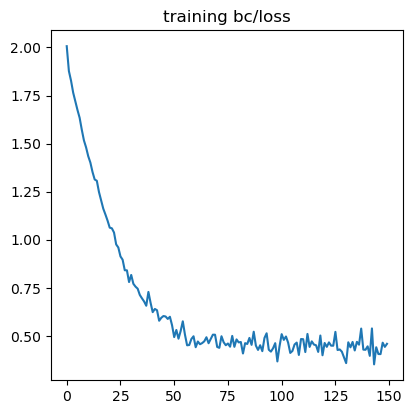

In [50]:
# # read csv
# with open('./log/progress.csv', 'r') as f:
    
#     # read header
#     header = f.readline().strip().split(',')
#     print(header)
    
#     # read data
#     data = []
#     for line in f:
#         data.append(list(map(float, line.strip().split(','))))
#     data = np.array(data)
#     print(data.shape)

import matplotlib.pyplot as plt

y_data = data[:, 5]
x_data = range(0, len(y_data)*2, 2)
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(data[:, 2])
# plt.plot(x_data, y_data)
plt.title("training bc/loss")
plt.show()

作成したログの名前を変更する

In [51]:
import os

new_name = '24-02-07_e150_cnn_3_nono'
# 新しいファイル名
new_csv_filename = './log/progress_' + new_name + '.csv'
new_txt_filename = './log/log_' + new_name + '.txt'

# 旧ファイル名から新ファイル名への変更
os.rename('./log/progress.csv', new_csv_filename)
os.rename('./log/log.txt', new_txt_filename)

from imitation.util import util
util.save_policy(bc_trainer.policy, './model/bc_policy_' + new_name)
bc_trainer.policy.save('./model/bc_policy' + new_name + '.zip')


In [48]:
import numpy as np

# 報酬（reward）の範囲を確認する
rewards = [entry['acts'] for entry in transitions]
print("Min Reward:", np.min(rewards))
print("Max Reward:", np.max(rewards))


Min Reward: -1.0
Max Reward: 1.0


In [207]:
print(rewards[2334])

[1. 1.]


In [30]:
import torch
import numpy as np
import time
from torchvision import transforms
from imitation.data import types
from imitation.util import util

# 連続値の観測空間の場合、ランダムなデータを生成
# your_observation = np.random.uniform(low=env1.observation_space.low, high=env1.observation_space.high, size=env1.observation_space.shape)
# your_observation = transitions[0]['obs']
your_observation = reshaped_all_expert_data[0]['images'][623]
print(your_observation.shape)
# # 前処理の定義
# preprocess = transforms.Compose([
#     transforms.Resize((224, 224)),  # サイズの調整
#     transforms.ToTensor(),          # テンソルに変換
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 正規化
# ])
# # NumPy配列に変換してからPIL Imageに変換
# your_observation_array = (your_observation * 255).astype(np.uint8).transpose((1, 2, 0))
# your_observation_image = Image.fromarray(your_observation_array)

# # 画像に前処理を適用
# processed_image = preprocess(your_observation_image)


# # モデルの出力を計算
# with torch.no_grad():
#     # 計測開始
#     start = time.time()

#     observation_tensor = torch.tensor(your_observation, dtype=torch.float32).unsqueeze(0).to("cuda")
    
#     predicted_action1 = bc_trainer.policy(observation_tensor)
#     predicted_action2 = recon_bc(observation_tensor)
    
#     # 計測終了
#     end = time.time()

# 計測開始
start1 = time.time()

predicted_action1 = bc_trainer.policy.predict(your_observation)

# 計測終了
end1 = time.time()

# 計測開始
start2 = time.time()

# predicted_action2 = recon_bc.predict(your_observation)

# 計測終了
end2 = time.time()


# print("Predicted Action:", predicted_action1)
# print("Predicted Action:", predicted_action2)

predicted_action1 = predicted_action1[0]
# predicted_action2 = predicted_action2[0]

print("Predicted Action:", predicted_action1)
# print("Predicted Action:", predicted_action2)

# 計測時間を表示 (hz: 1秒間に何回処理が実行されたか)
print(f"Time: {end1 - start1}")
print(f"Hz: {1 / (end1 - start1)}")
# print(f"Time: {end2 - start2}")
# print(f"Hz: {1 / (end2 - start2)}")



# print(env1.action_space.shape)
# print(predicted_action1.shape)

(3, 224, 224)
Predicted Action: [0.26403597 0.4815161 ]
Time: 0.006000518798828125
Hz: 166.65225683407502


In [23]:
bc_trainer.policy.save('./model/bc_trainer_policy.zip')

In [22]:
from imitation.util import util
util.save_policy(bc_trainer.policy, './model/bc_policy_24-02-07_e60_cnn_1')

In [27]:
from imitation.algorithms import bc
recon_bc = bc.reconstruct_policy('./model/bc_policy_24-02-05_e20', device='cuda')

AssertionError: 

In [168]:
print(observation_tensor.shape)
print(your_observation.shape)

torch.save(bc_trainer.policy.state_dict(), './model/bc_trainer_policy.pth')

torch.Size([1, 224, 224, 3])
(3, 224, 224)


In [166]:
import torch
from torch2trt import torch2trt
# 学習済みのBCモデルを保存
torch.save(bc_trainer.policy.state_dict(), './model/bc_trainer_policy.pth')

# 保存したpthファイルをtrtファイルに変換
dummy_input = torch.randn(1, 3, 224, 224).cuda()
trt_model = torch2trt(bc_trainer.policy, [dummy_input], fp16_mode=True)
# trt_model = torch2trt(bc_trainer.policy, [dummy_input], fp16_mode=True, max_workspace_size=1<<25)

observation_tensor = torch.tensor(your_observation, dtype=torch.float32)
observation_tensor = observation_tensor.unsqueeze(0)
action = trt_model(observation_tensor)
print(action)

ModuleNotFoundError: No module named 'torch2trt'